In [1]:
import librosa
import librosa.display
import scipy.io.wavfile
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn
import IPython.display as ipd
import os 
import math
import numpy as np
import warnings

## be cautious
warnings.filterwarnings("ignore")
##

## HYPERPARAMETER
FREQUENCY = 16000

# load a wave data
def load_wave_data(file_name, audio_dir="./"):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=FREQUENCY)
    return x,fs

# change wave data to mfcc
def calculate_mfcc(x, n_fft=2048, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft)
    mfcc = librosa.feature.mfcc(S=melsp)
    mfcc = preprocessing.scale(mfcc, axis=1)
    return mfcc

# display wave in plots
def show_wave(x, wave_name):
    print(wave_name)
    plt.plot(x)
    plt.show()

# display mfcc in heatmap
def show_mfcc(mfcc, fs, wave_name):
    print(wave_name)
    librosa.display.specshow(mfcc, sr=fs)
    plt.colorbar()
    plt.show()

    
# calculate SNR 
#axis = Axis along which the mean is to be computed
#ddof = Degree of freedom correction for Standard Deviation
#def calculate_snr(a, axis = 0, ddof = 0): 
#    a = np.asanyarray(a) 
#    m = a.mean(axis) 
#    sd = a.std(axis = axis, ddof = ddof)
#    return np.where(sd == 0, 0, m / sd) 


#SNR = 20log10(amplitude(signal)/amplitude(noise)), amplitude of signal = RMS(signal)
def calculate_snr(audio, noise):
    signal = audio-noise
    amp_signal = np.sqrt(np.mean((signal)**2))
    #print(amp_signal)
    amp_noise = np.sqrt(np.mean(noise**2))
    #print(amp_noise)
    snr = 20 * math.log10(amp_signal / amp_noise)
    return amp_noise, snr
    
# data augmentation: add white noise
def generate_white_noise(x, rate=0.005):
    noise = rate*np.random.normal(0, 1, len(x))
    return noise

#generate white noise while SNR is equal to adv example
def generate_wn2adv(audio, audio_adv):
    noise_white = generate_white_noise(audio, 10) # generate white noise
    noise_adv = audio_adv - audio # calculate adv perturbation(noise)
    
    audio_white = audio + noise_white
    audio_white = audio_white.astype('int16')
    amp_noise_white, snr_white = calculate_snr(audio_white, noise_white) #calculate amp of white noise and white SNR
    amp_noise_adv, snr_adv = calculate_snr(audio_adv, noise_adv) #calculate amp of adv perturbation and adv SNR 
    
    print("snr_adv : " + str(snr_adv))
    print("snr_wn : " + str(snr_white))
    snr_old = snr_white
    amp_signal = np.sqrt(np.mean(audio**2)) #original audio(signal) RMS
    amp_noise_wn2adv = amp_signal / (10**(snr_adv/20)) #calculate necessary amp of white noise using adv SNR
    rate = amp_noise_wn2adv / amp_noise_white #calculate rate
    noise_new = 10*rate * noise_white #generate new white noise by multiplying rate to original white noise
    
    snr_white = calculate_snr(audio + noise_new, noise_new)[1] #calculate new white noise SNR
    print("snr_adv : " + str(snr_adv))
    print("snr_wn : " + str(snr_white))
    plt.plot(noise_new)
    plt.show()
    
    return audio + noise_new, snr_old, noise_new

def signal_analysis(audio, filename = "input audio"):
    mfcc = calculate_mfcc(audio)
    print("wave size:{0}\nsampling rate:{1}\nmfcc size:{2}\n".format(audio.shape, FREQUENCY, mfcc.shape))
    show_wave(audio, filename)
    show_mfcc(mfcc, FREQUENCY, filename)

In [ ]:
speaker = ["Kitt","Westwick","Griffin","Izzard","Thomas","McClintock","Wright","Noriega","Asner",
           "Ramirez","Cassidy","Hendrix","Tomlinson","Roth","Wallach","Moss","Fanning","Burstyn",
           "Wong","Yung","Hirsch","Atack","Hashmi","Macken","Braeden","Dane","McCormack","Roberts",
           "Estrada","Andrews","Borgnine","Hudson","Morales","Harris","Levy","Derbez","Green",
           "Longoria","Lynch","Miller"]

speaker_adv = ["Kitt_adv","Westwick_adv","Griffin_adv","Izzard_adv","Thomas_adv","McClintock_adv",
               "Wright_adv","Noriega_adv","Asner_adv","Ramirez_adv","Cassidy_adv","Hendrix_adv",
               "Tomlinson_adv","Roth_adv","Wallach_adv","Moss_adv","Fanning_adv","Burstyn_adv",
               "Wong_adv","Yung_adv","Hirsch_adv","Atack_adv","Hashmi_adv","Macken_adv","Braeden_adv",
               "Dane_adv","McCormack_adv","Roberts_adv","Estrada_adv","Andrews_adv","Borgnine_adv",
               "Hudson_adv","Morales_adv","Harris_adv","Levy_adv","Derbez_adv","Green_adv",
               "Longoria_adv","Lynch_adv","Miller_adv"]

In [ ]:

clean_audio_path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC/"
adv_audio_path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_adv/"

load_audio = []
audio_org = []
audio_adv = []
labels_org = []
labels_adv = []

#load clean audio files 
for spk in speaker:
    labels = []
    for utter in os.listdir(clean_audio_path + spk):
        if '.wav' in utter:
            labels.append(utter)
    labels.sort()
    for filename in labels:
        load_audio = scipy.io.wavfile.read(clean_audio_path + spk + "/"  + filename)
        #load_audio = load_wave_data(filename,clean_audio_path + spk + "/")
        audio_org.append(load_audio[1])
    labels_org.extend(labels)

        
#load adv audio files
for spk in speaker_adv:
    labels = []
    for utter in os.listdir(adv_audio_path + spk):
        if '.wav' in utter:
            labels.append(utter)
    labels.sort()
    for filename in labels:
        load_audio = scipy.io.wavfile.read(adv_audio_path + spk + "/"  + filename)
        #load_audio = load_wave_data(filename,adv_audio_path + spk + "/")
        audio_adv.append(load_audio[1])
    labels_adv.extend(labels)


In [ ]:
for i in range(0,np.shape(labels_org)[0]):
    print(str(i) + " / " + labels_org[i] + " , " + labels_adv[i])

In [ ]:
NUM_of_UTTER = [93,45,45,139,45,45,108,45,136,45,45,45,45,102,45,45,94,45,45,45,
                100,45,190,45,67,45,45,45,45,46,45,45,45,45,45,45,106,82,44,122]

print(sum(NUM_of_UTTER[0:40]))

In [ ]:
import scipy
i=0
for i in range(0,1):
        spk = speaker[i] + "_wn"
        for i in range(sum(NUM_of_UTTER[0:i]), sum(NUM_of_UTTER[0:i+1])):    
            path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_wn/" + spk + "/" + labels_wn[i]
            scipy.io.wavfile.write(path, FREQUENCY, audio_wn[i])
            #librosa.output.write_wav(path, audio_wn[i], FREQUENCY)
############################################################# END

In [ ]:
audio_org = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC/Kitt/5r0dWxy17C8_00002.wav")[1]
audio_adv = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_adv/Kitt_adv/5r0dWxy17C8_00002_adv.wav")[1]
audio_wn = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_wn/Kitt_wn/5r0dWxy17C8_00002_wn.wav")[1]
print(len(audio_wn))

In [ ]:
noise_adv = audio_adv - audio_org
noise_wn = audio_wn - audio_org
print(np.mean(noise_wn**2))
#print(noise_adv, noise_wn)
snr_adv = calculate_snr(audio_adv, noise_adv)[1] #calculate amp of adv perturbation and adv SNR

snr_wn = calculate_snr(audio_wn, noise_wn)[1]
print(snr_adv, snr_wn)
#print(len(noise_wn), len(noise_adv))
np.set_printoptions(threshold=np.inf)
#print(noise_adv)


In [ ]:
noise_wn = generate_wn2adv(audio_org, audio_adv)[2]
print(noise_wn)
scipy.io.wavfile.write("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_wn_2/noise.wav", FREQUENCY, noise_wn)


In [ ]:
audio_org = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/Kitt_73.wav")[1]
audio_adv = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/5r0dWxy17C8_00002_adv.wav")[1]
audio_wn = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/whitenoise.wav")[1]
print(len(audio_org), len(audio_adv), len(audio_adv))

adv_noise = audio_adv - audio_org
wn_noise = audio_wn - audio_org

print(calculate_snr(audio_adv, adv_noise))
print(calculate_snr(audio_wn, wn_noise))


In [2]:
##################PYTHON3 ADD WHITE NOISE TO VOXCELEB DATASET
import array
import math
import numpy as np
import random
import wave
import scipy.io.wavfile
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os 
import warnings
FREQUENCY = 16000
duration = 60
rate = 1000
noise = rate*np.random.normal(0, 1, FREQUENCY*duration)
noise_int = noise.astype('int16')
scipy.io.wavfile.write("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/whitenoise.wav", FREQUENCY, noise_int)
#print(noise_int)

In [3]:
speaker = ["Kitt","Westwick","Griffin","Izzard","Thomas","McClintock","Wright","Noriega","Asner",
           "Ramirez","Cassidy","Hendrix","Tomlinson","Roth","Wallach","Moss","Fanning","Burstyn",
           "Wong","Yung","Hirsch","Atack","Hashmi","Macken","Braeden","Dane","McCormack","Roberts",
           "Estrada","Andrews","Borgnine","Hudson","Morales","Harris","Levy","Derbez","Green",
           "Longoria","Lynch","Miller"]

speaker_adv = ["Kitt_adv","Westwick_adv","Griffin_adv","Izzard_adv","Thomas_adv","McClintock_adv",
               "Wright_adv","Noriega_adv","Asner_adv","Ramirez_adv","Cassidy_adv","Hendrix_adv",
               "Tomlinson_adv","Roth_adv","Wallach_adv","Moss_adv","Fanning_adv","Burstyn_adv",
               "Wong_adv","Yung_adv","Hirsch_adv","Atack_adv","Hashmi_adv","Macken_adv","Braeden_adv",
               "Dane_adv","McCormack_adv","Roberts_adv","Estrada_adv","Andrews_adv","Borgnine_adv",
               "Hudson_adv","Morales_adv","Harris_adv","Levy_adv","Derbez_adv","Green_adv",
               "Longoria_adv","Lynch_adv","Miller_adv"]

speaker_wn = ["Kitt_wn","Westwick_wn","Griffin_wn","Izzard_wn","Thomas_wn","McClintock_wn","Wright_wn","Noriega_wn","Asner_wn",
           "Ramirez_wn","Cassidy_wn","Hendrix_wn","Tomlinson_wn","Roth_wn","Wallach_wn","Moss_wn","Fanning_wn","Burstyn_wn",
           "Wong_wn","Yung_wn","Hirsch_wn","Atack_wn","Hashmi_wn","Macken_wn","Braeden_wn","Dane_wn","McCormack_wn","Roberts_wn",
           "Estrada_wn","Andrews_wn","Borgnine_wn","Hudson_wn","Morales_wn","Harris_wn","Levy_wn","Derbez_wn","Green_wn",
           "Longoria_wn","Lynch_wn","Miller_wn"]


In [4]:
## be cautious
warnings.filterwarnings("ignore")
##

def cal_adjusted_rms(clean_rms, snr):
    a = float(snr) / 20
    noise_rms = clean_rms / (10**a) 
    return noise_rms

def cal_amp(wf):
    buffer = wf.readframes(wf.getnframes())
    # The dtype depends on the value of pulse-code modulation. The int16 is set for 16-bit PCM.
    amptitude = (np.frombuffer(buffer, dtype="int16")).astype(np.float64)
    return amptitude

def cal_rms(amp):
    return np.sqrt(np.mean(np.square(amp), axis=-1))

def save_waveform(output_path, params, amp):
    output_file = wave.Wave_write(output_path)
    output_file.setparams(params) #nchannels, sampwidth, framerate, nframes, comptype, compname
    output_file.writeframes(array.array('h', amp.astype(np.int16)).tobytes() )
    output_file.close()

def calculate_snr(audio, noise):
    signal = audio-noise
    amp_signal = np.sqrt(np.mean(signal**2))
    #print(amp_signal)
    amp_noise = np.sqrt(np.mean(noise**2))
    #print(amp_noise)
    snr = 20 * math.log10(amp_signal / amp_noise)
    return snr

In [8]:
clean_audio_path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC/"
adv_audio_path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_adv/"

load_audio = []
audio_org = []
audio_adv = []
labels_org = []
labels_adv = []

#load clean audio files 
for spk in speaker:
    labels = []
    for utter in os.listdir(clean_audio_path + spk):
        if '.wav' in utter:
            labels.append(utter)
    labels.sort()
    labels_org.extend(labels)

#load adv audio files
for spk in speaker_adv:
    labels = []
    for utter in os.listdir(adv_audio_path + spk):
        if '.wav' in utter:
            labels.append(utter)
    labels.sort()
    labels_adv.extend(labels)



In [9]:
for i in range(0,np.shape(labels_org)[0]):
    print(str(i) + " / " + labels_org[i] + " , " + labels_adv[i])

0 / 5r0dWxy17C8_00001.wav , 5r0dWxy17C8_00001_adv.wav
1 / 5r0dWxy17C8_00002.wav , 5r0dWxy17C8_00002_adv.wav
2 / 5r0dWxy17C8_00003.wav , 5r0dWxy17C8_00003_adv.wav
3 / 5r0dWxy17C8_00004.wav , 5r0dWxy17C8_00004_adv.wav
4 / 5r0dWxy17C8_00005.wav , 5r0dWxy17C8_00005_adv.wav
5 / 5r0dWxy17C8_00006.wav , 5r0dWxy17C8_00006_adv.wav
6 / 5r0dWxy17C8_00007.wav , 5r0dWxy17C8_00007_adv.wav
7 / 5r0dWxy17C8_00008.wav , 5r0dWxy17C8_00008_adv.wav
8 / 5r0dWxy17C8_00009.wav , 5r0dWxy17C8_00009_adv.wav
9 / 5r0dWxy17C8_00010.wav , 5r0dWxy17C8_00010_adv.wav
10 / 5r0dWxy17C8_00011.wav , 5r0dWxy17C8_00011_adv.wav
11 / 5r0dWxy17C8_00012.wav , 5r0dWxy17C8_00012_adv.wav
12 / 5r0dWxy17C8_00013.wav , 5r0dWxy17C8_00013_adv.wav
13 / 5r0dWxy17C8_00014.wav , 5r0dWxy17C8_00014_adv.wav
14 / 5r0dWxy17C8_00015.wav , 5r0dWxy17C8_00015_adv.wav
15 / 5r0dWxy17C8_00016.wav , 5r0dWxy17C8_00016_adv.wav
16 / 5r0dWxy17C8_00017.wav , 5r0dWxy17C8_00017_adv.wav
17 / 5r0dWxy17C8_00018.wav , 5r0dWxy17C8_00018_adv.wav
18 / 5r0dWxy17C8_000

In [14]:
noise_file = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/whitenoise.wav"
noise_wav = wave.open(noise_file, "r")
noise_amp = cal_amp(noise_wav)

#calculate snr for all adv

NUM_of_UTTER = [158,73,50,240,54,74,185,48,136,63,66,45,45,102,45,45,94,45,45,45,
                100,45,190,45,67,45,45,45,45,46,45,45,45,45,45,45,106,82,44,122]

for i in range(0,40):
    for j in range(sum(NUM_of_UTTER[0:i]), sum(NUM_of_UTTER[0:i+1])):
        filepath_org = clean_audio_path + speaker[i] + "/" + str(labels_org[j])
        filepath_adv = adv_audio_path + speaker_adv[i] + "/" + str(labels_adv[j])
        clean_wav = wave.open(filepath_org, "r")
        adv_wav = wave.open(filepath_adv, "r")
        clean_amp = cal_amp(clean_wav)
        clean_rms = cal_rms(clean_amp)
        adv_amp = cal_amp(adv_wav)
        adv_noise = adv_amp - clean_amp

        SNR = calculate_snr(adv_amp, adv_noise)
        print(SNR)
        divided_noise_amp = noise_amp[0:len(clean_amp)]

        noise_rms = cal_rms(divided_noise_amp)

        snr = 20 ### change to desired SNR

        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr)
        adjusted_noise_amp = divided_noise_amp * (adjusted_noise_rms / noise_rms) 

        mixed_amp = (clean_amp + adjusted_noise_amp)

        max_int16 = np.iinfo(np.int16).max
        min_int16 = np.iinfo(np.int16).min
        if mixed_amp.max(axis=0) > max_int16 or mixed_amp.min(axis=0) < min_int16:
            if mixed_amp.max(axis=0) >= abs(mixed_amp.min(axis=0)): 
                reduction_rate = max_int16 / mixed_amp.max(axis=0)
            else :
                reduction_rate = min_int16 / mixed_amp.min(axis=0)
            mixed_amp = mixed_amp * (reduction_rate)
            clean_amp = clean_amp * (reduction_rate)

        path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_wn_20/" + speaker[i] + "_wn/" + labels_org[j]
        save_waveform(path, clean_wav.getparams(), mixed_amp)

16.833127406986122
20.348590656497088
18.516803173892175
15.109496357186085
23.317931794681073
21.047754068582233
22.17038033432302
22.037359801347996
20.698759764241462
20.442928398327574
22.274432288080813
21.440985537347853
21.174637477871503
22.49120354751205
18.88856585556806
23.345031665527124
21.190598676734385
26.48872835459475
22.965650742151876
22.121766105261067
26.387364998299677
22.9674047004475
23.060510910324368
23.77146270732327
21.389388723153196
22.68063806501356
25.15127745949727
23.46694437413642
20.529697090862662
25.329949170607847
26.68318498880496
25.56963266903748
29.498332064189306
26.96564794200714
27.009086192344757
30.222774685022404
25.520250062087896
28.42323281524631
26.952175640627736
24.736126243179992
27.351197922313176
27.72644423509348
26.264532648752564
27.39037251784839
28.90801732903696
25.217528581390592
29.98271680953814
17.06429494334993
28.045178186651007
26.856936296925902
26.71736114283896
29.53104907293092
28.160768385414507
29.44890327432

23.635880974787934
22.713226178560415
20.24569761242916
20.048835990296755
22.329247566221532
22.35577725990715
20.559944464360875
20.966051010542046
22.774572758759277
22.206762225296725
18.85403930355258
19.738819326968272
20.52387451906787
18.271503555852288
22.10514705861103
19.899635085563652
18.62828860163795
21.60799595440636
21.3806482747963
18.103784907921224
23.910195255029368
22.308317122210003
20.82272417562869
23.672135156164064
27.378226948719405
25.88213677417622
27.951857707224228
27.82529085560065
26.528961537284744
30.169813526196823
24.907173285456842
28.534220275308677
24.141610759758226
23.275653681925036
28.77730456168628
24.04518289419751
18.288468488850572
18.247718955390415
25.15050960446773
27.39819445996169
26.73443694263537
22.735025398214013
23.637419464238654
17.378615936060044
24.545062606042624
22.53610371168505
27.269435754060613
25.026686860643338
26.940994719798702
24.0427483593521
24.366340189707827
24.479449880688698
24.136391168690547
22.0947570262

28.577449048484773
27.943091645537347
25.23892698380053
28.30168772780783
26.209786253076853
29.76012438202874
28.33386302738342
27.524626002060444
29.7414088590277
27.548819799166164
32.93877884509163
28.589158302206975
31.74344461153835
32.10334982837964
22.072836396867963
25.61377552452369
22.948801580338642
29.910264981495725
20.312155495241576
27.431915057197504
32.82748954652003
27.583738418225398
29.199900125683623
25.250828871787142
25.030607397930073
27.885206172773714
31.56719541602472
29.14706605059451
26.034840369882186
31.330526925761323
27.83040250074583
25.21289772319737
28.261547728109953
27.352843695079518
25.608459929343617
23.49257983080826
29.33165814524962
25.686604786254243
29.185706501669415
24.562880360137292
25.7316293529992
25.604086186944656
23.319122317543698
27.32876799648638
27.745517588881007
29.69603901625323
30.43417001813357
27.740485185234803
25.997710293139203
28.401154830496893
27.706732494055174
28.999535474936387
28.33284037973057
22.9904586462414

28.336482847521932
19.78034200907827
13.52652356518207
22.10371947495441
25.468634974345182
22.25772207495348
23.12251610188364
16.196060538627346
27.103377907681313
24.315010929036717
26.182467983383827
25.193073398159278
26.676828772708564
26.24937283329668
28.16388681573133
30.871573900347762
29.928301867542253
28.158391380828753
28.66878789722967
28.386783856339694
30.780305982302558
26.943035805058436
27.005990317189195
25.854007924864334
24.542984679590756
29.21757793792065
23.254096487280293
31.813148511560534
30.230157715500262
25.9905342698559
22.108919840565004
20.866106864999505
16.22643049939988
24.102065458849037
17.207651871319687
22.32132457366921
22.97678821801623
26.119534956037963
23.158223369789376
24.827599757287775
27.598310616370803
20.847020145071916
23.439896110607332
19.1019124995082
32.05886271718422
21.02247267345802
19.36423321894856
24.162680787979873
24.965882090668103
21.070068992073246
21.849026621287308
25.087776666263917
21.48244227533395
23.7062164083

19.11535264986671
23.319926151319294
19.3956940759783
17.42215189256865
20.412077831338344
23.18756607018678
22.003164245208715
22.875289785510624
20.344161714784036
19.884952946391394
12.2630061060126
18.38728423518778
21.567201578529442
24.918601923505307
30.66005149435997
29.3818005906043
28.68210306125794
25.745413290127214
24.429346040880873
30.714429694080692
33.14156648494094
29.53756365699327
21.804608728739495
23.690942298138186
23.259033407051398
22.121871986806056
22.231492898748314
23.248394177756957
19.816146661209157
15.457870594491439
25.46655868379417
31.079057487809855
21.44505344026446
28.735687030576933
30.2713183229262
28.81275058314795
30.356404532498047
31.285811815833284
30.4410678743282
29.261577037718453
29.090606750352727
28.864733619271078
26.691797551237833
24.958317308695342
27.545445335874817
28.449394236870162
23.19344918466154
27.00150648750675
20.75222187920517
25.437673300800352
27.55426640503559
27.108884009201823
25.34197851736314
17.591020674834862


24.312125694999658
32.13103740335369
28.658950135188178
27.003541051731897
20.828203684746406
20.45701051774859
21.850866085626336
25.79150133648244
17.0416123872397
25.918606536718222
20.132332233158397
22.469182745997824
21.43461758035679
24.736504625680197
18.87257149026005
22.69346216058508
23.431048438652034
20.1243981174286
18.858891921803323
22.32976550107702
24.634368522423095
29.459415658504717
23.49088444344251
18.679940459445092
24.484393962663017
20.171659800744266
23.291087110587707
21.71474762200831
27.947195155648945
18.537043158409265
20.729423692546703
23.778689426917147
25.494694133271224
24.15527102014222
22.562726946136358
18.650114769649363
22.23181687891726
25.66881759680184
29.21803123206141
23.167712533011265
17.14683132321041
17.522201515772934
18.546581555097564
24.257177869563392
27.721299235872788
25.872303004591632
26.861174711962654
28.72285434792414
27.004287758783736
26.420526960981583
26.25034356883333
23.550676817265625
24.744941336141622
21.2065679913

20.504328143769452
23.241671473038146
20.272593290396056
18.032625244934387
18.678800989971517
23.674439886113518
20.20774294806055
19.611997445199588
16.739153376007103
20.940880841047065
19.27954970995446
17.41782830992324
20.35541144908816
22.356779218652715
21.73519589217072
23.21625623890418
22.606033604155535
21.659304501931235
19.464576045746373
18.333977812004644
23.456477076536125
21.147896097647468
22.58507913484148
24.479189168713894
18.782372329044293
21.711236549575283
25.991621862907284
19.523604454698596
20.810180119623162
22.163781908963497
21.781545263939016
22.991020190421196
21.923314056070335
22.93111058046497
20.55563903874562
20.29544771232136
21.671636048597236
21.751083732030917
20.054297596826586
23.609710295236344
21.55239388265358
28.09495472861903
26.046489641308213
23.38317026283518
20.26956915916621
21.972447740365194
20.07374597309986
27.660965457567613
26.58444545727784
26.80985953461211
28.44788913878306
27.706708480543227
22.773680593778806
27.95995090

In [11]:
sum(NUM_of_UTTER[0:40])

2955

In [15]:
##################PYTHON3 ADD WHITE NOISE TO SITW DATASET

FREQUENCY = 16000
duration = 10
rate = 1000
noise = rate*np.random.normal(0, 1, FREQUENCY*duration)
noise_int = noise.astype('int16')
scipy.io.wavfile.write("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/whitenoise.wav", FREQUENCY, noise_int)
#print(noise_int)

In [17]:
speaker=["aevrk","aigus","anshb","arrjk","aspqn","avwul","awril","aymwb",
"bfeib","bklgt","bqrdo","btcrc","bxpyl","bzxqe","cbkmg","cbndy",
"ccdee","cenvp","cpgpu","cqlin","cryto","ctlyf","cvgyr","cwfdt",
"dawll","dcwdm","depem","dfpnq","dgwnx","ditod","dmegd","dnhzj",
"dohdw","duvqm","dvqaa","dvzrj","dxdtu","dxoes","dzjbh","eauem",
"edrpg","ehugq","ehvie","eibhj","erafb","focnp","fppfq","gakjo",
"gaqoj","gimlz","gmabl","gniae","gnkiu","gowjl","gprmf","gurmx",
"gusim","hgigw","hlojf","hmzdf","hrjdw","hsjto","hukro","hwqmj",
"ialzb","iaynp","idmbr","iffpi","ifuot","ipvmq","ircoj","irslh",
"isoyi","ivyxz","jgxuu","jjree","jkkzl","jtexh","jxjny","jyfan",
"kdwoa","kehnn","kfpwq","kndbz","koxyq","koybi","kpzvw","kvszv",
"kywxo","kzjsa","lcjyj","lckcz","lpxkx","lqrjy","luqez","lyzyj",
"mevkw","mjmrt","mjoaj","mmtbn","mvidw","mxmgd","nbwpj","nhbif",
"nhqgu","nkdao","nlnva","nmmdx","nnbbr","nqgsk","nqyqn","nxdfq",
"nylwv","oabkg","obink","ofndv","oihuh","oqqrm","oymcs","pghkn",
"pjufx","pkjap","pofat","pqwaa","prfmo","pxfps","pzqep","qbvwh",
"qclqh","qdfbs","qhbtu","qnipz","qoyox","qsyhr","qyztf","rbtgb",
"rdidf","rftdg","rggnl","rkvch","rnyzw","rvlny","sbtlt","scvke",
"sfiwm","smlss","sojxg","sugoz","swkiz","syfhi","tfnja","thdnl",
"thoab","tlkkn","tmkfu","tmtlf","tsxyo","tvhcy","tydjw","ubsqm",
"ucnqj","ucpes","ugjkj","uhovd","ujewn","unuif","urhae","uxopa",
"vauuw","vavfw","vfyvf","vfzmy","vjtaf","vkthc","vrvul","vvmho",
"whuqp","wigxq","wrjph","wuwgf","wypbw","wzmlq","xjwtg","xlvdn",
"xlvqu","xocwg","xpcep","xqtvd","xrvzx","yaiwb","ybylc","ycmwp",
"yfywx","yhlin","ymqhi","ynydz","yrnqr","yvkcq","yyypi","yzdin",
"yzdpz","zgafe","zgyik","zhocn","zjfsf","zpjtl","zwmog","zychx","zzeiy"]

speaker_adv=["aevrk_adv","aigus_adv","anshb_adv","arrjk_adv","aspqn_adv","avwul_adv","awril_adv","aymwb_adv",
"bfeib_adv","bklgt_adv","bqrdo_adv","btcrc_adv","bxpyl_adv","bzxqe_adv","cbkmg_adv","cbndy_adv",
"ccdee_adv","cenvp_adv","cpgpu_adv","cqlin_adv","cryto_adv","ctlyf_adv","cvgyr_adv","cwfdt_adv",
"dawll_adv","dcwdm_adv","depem_adv","dfpnq_adv","dgwnx_adv","ditod_adv","dmegd_adv","dnhzj_adv",
"dohdw_adv","duvqm_adv","dvqaa_adv","dvzrj_adv","dxdtu_adv","dxoes_adv","dzjbh_adv","eauem_adv",
"edrpg_adv","ehugq_adv","ehvie_adv","eibhj_adv","erafb_adv","focnp_adv","fppfq_adv","gakjo_adv",
"gaqoj_adv","gimlz_adv","gmabl_adv","gniae_adv","gnkiu_adv","gowjl_adv","gprmf_adv","gurmx_adv",
"gusim_adv","hgigw_adv","hlojf_adv","hmzdf_adv","hrjdw_adv","hsjto_adv","hukro_adv","hwqmj_adv",
"ialzb_adv","iaynp_adv","idmbr_adv","iffpi_adv","ifuot_adv","ipvmq_adv","ircoj_adv","irslh_adv",
"isoyi_adv","ivyxz_adv","jgxuu_adv","jjree_adv","jkkzl_adv","jtexh_adv","jxjny_adv","jyfan_adv",
"kdwoa_adv","kehnn_adv","kfpwq_adv","kndbz_adv","koxyq_adv","koybi_adv","kpzvw_adv","kvszv_adv",
"kywxo_adv","kzjsa_adv","lcjyj_adv","lckcz_adv","lpxkx_adv","lqrjy_adv","luqez_adv","lyzyj_adv",
"mevkw_adv","mjmrt_adv","mjoaj_adv","mmtbn_adv","mvidw_adv","mxmgd_adv","nbwpj_adv","nhbif_adv",
"nhqgu_adv","nkdao_adv","nlnva_adv","nmmdx_adv","nnbbr_adv","nqgsk_adv","nqyqn_adv","nxdfq_adv",
"nylwv_adv","oabkg_adv","obink_adv","ofndv_adv","oihuh_adv","oqqrm_adv","oymcs_adv","pghkn_adv",
"pjufx_adv","pkjap_adv","pofat_adv","pqwaa_adv","prfmo_adv","pxfps_adv","pzqep_adv","qbvwh_adv",
"qclqh_adv","qdfbs_adv","qhbtu_adv","qnipz_adv","qoyox_adv","qsyhr_adv","qyztf_adv","rbtgb_adv",
"rdidf_adv","rftdg_adv","rggnl_adv","rkvch_adv","rnyzw_adv","rvlny_adv","sbtlt_adv","scvke_adv",
"sfiwm_adv","smlss_adv","sojxg_adv","sugoz_adv","swkiz_adv","syfhi_adv","tfnja_adv","thdnl_adv",
"thoab_adv","tlkkn_adv","tmkfu_adv","tmtlf_adv","tsxyo_adv","tvhcy_adv","tydjw_adv","ubsqm_adv",
"ucnqj_adv","ucpes_adv","ugjkj_adv","uhovd_adv","ujewn_adv","unuif_adv","urhae_adv","uxopa_adv",
"vauuw_adv","vavfw_adv","vfyvf_adv","vfzmy_adv","vjtaf_adv","vkthc_adv","vrvul_adv","vvmho_adv",
"whuqp_adv","wigxq_adv","wrjph_adv","wuwgf_adv","wypbw_adv","wzmlq_adv","xjwtg_adv","xlvdn_adv",
"xlvqu_adv","xocwg_adv","xpcep_adv","xqtvd_adv","xrvzx_adv","yaiwb_adv","ybylc_adv","ycmwp_adv",
"yfywx_adv","yhlin_adv","ymqhi_adv","ynydz_adv","yrnqr_adv","yvkcq_adv","yyypi_adv","yzdin_adv",
"yzdpz_adv","zgafe_adv","zgyik_adv","zhocn_adv","zjfsf_adv","zpjtl_adv","zwmog_adv","zychx_adv","zzeiy_adv"]


                                                                                                                                                                           



In [42]:
import os
import numpy as np
clean_audio_path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_SITW_2_clean_wav/"
adv_audio_path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_SITW_2_adv_wav/"

load_audio = []
audio_org = []
audio_adv = []
labels_org = []
labels_adv = []

#load clean audio files 
for spk in speaker:
    labels = []
    for utter in os.listdir(clean_audio_path + spk):
        if '.wav' in utter:
            labels.append(utter)
    labels.sort()
    labels_org.extend(labels)

#load adv audio files
for spk in speaker_adv:
    labels = []
    for utter in os.listdir(adv_audio_path + spk):
        if '.wav' in utter:
            labels.append(utter)
    labels.sort()
    labels_adv.extend(labels)

In [43]:
for i in range(0,np.shape(labels_org)[0]):
    print(str(i) + " / " + labels_org[i] + " , " + labels_adv[i])

0 / aevrk_01.wav , aevrk_01_adv.wav
1 / aevrk_02.wav , aevrk_02_adv.wav
2 / aevrk_03.wav , aevrk_03_adv.wav
3 / aevrk_04.wav , aevrk_04_adv.wav
4 / aevrk_05.wav , aevrk_05_adv.wav
5 / aevrk_06.wav , aevrk_06_adv.wav
6 / aevrk_07.wav , aevrk_07_adv.wav
7 / aevrk_08.wav , aevrk_08_adv.wav
8 / aevrk_09.wav , aevrk_09_adv.wav
9 / aevrk_10.wav , aevrk_10_adv.wav
10 / aigus_01.wav , aigus_01_adv.wav
11 / aigus_02.wav , aigus_02_adv.wav
12 / aigus_03.wav , aigus_03_adv.wav
13 / aigus_04.wav , aigus_04_adv.wav
14 / aigus_05.wav , aigus_05_adv.wav
15 / aigus_06.wav , aigus_06_adv.wav
16 / aigus_07.wav , aigus_07_adv.wav
17 / aigus_08.wav , aigus_08_adv.wav
18 / anshb_01.wav , anshb_01_adv.wav
19 / anshb_02.wav , anshb_02_adv.wav
20 / anshb_03.wav , anshb_03_adv.wav
21 / anshb_04.wav , anshb_04_adv.wav
22 / anshb_05.wav , anshb_05_adv.wav
23 / arrjk_01.wav , arrjk_01_adv.wav
24 / arrjk_02.wav , arrjk_02_adv.wav
25 / arrjk_03.wav , arrjk_03_adv.wav
26 / arrjk_04.wav , arrjk_04_adv.wav
27 / arrjk_

In [41]:
sum(NUM_of_UTTER[0:209])

1370

In [47]:
noise_file = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/whitenoise.wav"
noise_wav = wave.open(noise_file, "r")
noise_amp = cal_amp(noise_wav)

SITW_SNR = []

#calculate snr for all adv

for i in range(0,209):
    for j in range(sum(NUM_of_UTTER[0:i]), sum(NUM_of_UTTER[0:i+1])):
        filepath_org = clean_audio_path + speaker[i] + "/" + str(labels_org[j])
        filepath_adv = adv_audio_path + speaker_adv[i] + "/" + str(labels_adv[j])
        clean_wav = wave.open(filepath_org, "r")
        adv_wav = wave.open(filepath_adv, "r")
        clean_amp = cal_amp(clean_wav)
        clean_rms = cal_rms(clean_amp)
        adv_amp = cal_amp(adv_wav)
        adv_noise = adv_amp - clean_amp

        SNR = calculate_snr(adv_amp, adv_noise)
        SITW_SNR.append(SNR)
        divided_noise_amp = noise_amp[0:len(clean_amp)]

        noise_rms = cal_rms(divided_noise_amp)

        snr = 20 ### change to desired SNR

        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr)
        adjusted_noise_amp = divided_noise_amp * (adjusted_noise_rms / noise_rms) 

        mixed_amp = (clean_amp + adjusted_noise_amp)

        max_int16 = np.iinfo(np.int16).max
        min_int16 = np.iinfo(np.int16).min
        if mixed_amp.max(axis=0) > max_int16 or mixed_amp.min(axis=0) < min_int16:
            if mixed_amp.max(axis=0) >= abs(mixed_amp.min(axis=0)): 
                reduction_rate = max_int16 / mixed_amp.max(axis=0)
            else :
                reduction_rate = min_int16 / mixed_amp.min(axis=0)
            mixed_amp = mixed_amp * (reduction_rate)
            clean_amp = clean_amp * (reduction_rate)

        path = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_SITW_2_wn_20/" + speaker[i] + "/" + labels_org[j]
        save_waveform(path, clean_wav.getparams(), mixed_amp)

In [30]:
sum(SITW_SNR) / 296

21.54623135898026

In [5]:
NUM_of_UTTER = [10,8,12,4,3,4,7,4,3,3,3,11,10,12,3,5,3,8,6,6,10,3,3,3,9,4,7,9,3,4,3,6,6,13,14,2,3,16,7,4,4,3,10,3,9,20,5,12,4,4,7,3,11,5,
                4,17,4,9,10,5,4,3,7,8,3,4,5,4,18,3,8,3,7,16,3,8,4,4,5,4,6,7,10,6,4,8,6,13,4,10,6,5,5,6,4,6,8]
print(sum(NUM_of_UTTER[0:97]))

638


In [37]:
NUM_of_UTTER=[10,
8,
5,
12,
4,
5,
4,
8,
5,
4,
4,
3,
4,
10,
5,
6,
3,
3,
7,
4,
10,
24,
6,
8,
1,
3,
3,
3,
3,
8,
11,
10,
17,
12,
3,
4,
8,
23,
5,
7,
4,
5,
3,
3,
8,
6,
11,
3,
3,
5,
4,
5,
6,
2,
10,
10,
6,
3,
3,
7,
3,
9,
9,
6,
4,
2,
8,
8,
5,
6,
7,
8,
9,
2,
3,
4,
4,
12,
3,
6,
6,
13,
14,
2,
4,
3,
16,
7,
4,
3,
19,
4,
8,
3,
10,
13,
3,
12,
10,
3,
4,
14,
7,
9,
3,
6,
20,
9,
4,
3,
3,
3,
5,
5,
12,
4,
4,
7,
7,
7,
3,
11,
4,
4,
5,
4,
13,
6,
17,
4,
9,
10,
4,
9,
7,
2,
5,
4,
3,
5,
11,
7,
4,
8,
3,
5,
4,
5,
5,
4,
4,
18,
6,
7,
4,
3,
8,
3,
7,
4,
3,
7,
16,
3,
6,
3,
4,
5,
5,
3,
8,
7,
4,
4,
11,
5,
8,
4,
6,
7,
3,
10,
5,
4,
23,
6,
4,
6,
8,
6,
13,
4,
10,
4,
6,
5,
4,
8,
5,
4,
5,
6,
4,
4,
17,
5,
6,
8,
8]

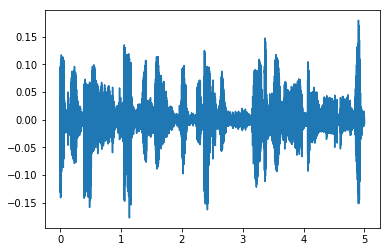

In [81]:
import sys
import librosa
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
#audio_org = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC/Kitt/5r0dWxy17C8_00002.wav")[1]
#audio_adv = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_adv/Kitt_adv/5r0dWxy17C8_00002_adv.wav")[1]
#audio_wn = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_wn/Kitt_wn/5r0dWxy17C8_00002_wn.wav")[1]

#args = sys.argv
filename = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC/Kitt/5r0dWxy17C8_00002.wav"

y,sr=librosa.load(filename)#音声ファイルの読み込み
totaltime = len(y)/sr#動画の時間(秒)
time = np.arange(0, totaltime, 1/sr)#時間の配列を作成
#mpl.rcParams["agg.path.chunksize"]=100000#データ数が多く、overflowErrorが出た場合これを入れるといいみたいです
plt.plot(time,y)
plt.savefig("poster_clean.png")

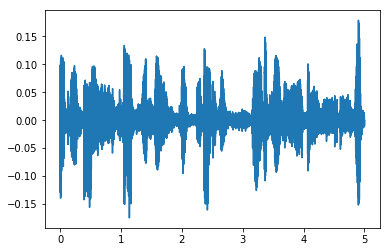

In [84]:
import sys
import librosa
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
#audio_org = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC/Kitt/5r0dWxy17C8_00002.wav")[1]
#audio_adv = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_adv/Kitt_adv/5r0dWxy17C8_00002_adv.wav")[1]
#audio_wn = scipy.io.wavfile.read("/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_wn/Kitt_wn/5r0dWxy17C8_00002_wn.wav")[1]

#args = sys.argv
filename_1 = "/home/Yuunin/adversarial/audio_adversarial_examples/wavfile/eval/dataset/audio_VC_adv/Kitt_adv/5r0dWxy17C8_00002_adv.wav"

y_1,sr=librosa.load(filename_1)#音声ファイルの読み込み
totaltime = len(y_1)/sr#動画の時間(秒)
time = np.arange(0, totaltime, 1/sr)#時間の配列を作成
#time=np.linspace(0,1,len(y_1/100))
#mpl.rcParams["agg.path.chunksize"]=100000#データ数が多く、overflowErrorが出た場合これを入れるといいみたいです
plt.plot(time,y_1)
plt.savefig("poster_adv.png")

In [85]:
y - y_1
x=np.linspace(0,5,len(y))

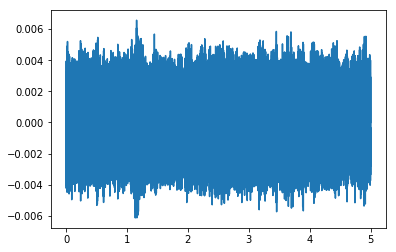

In [87]:
plt.plot(x,y-y_1)
plt.savefig("poster_noise.png")